In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime,timedelta
import squarify
import re 
import warnings
warnings.filterwarnings("ignore")
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score,recall_score,precision_score, confusion_matrix
from sklearn.metrics import silhouette_score

In [2]:
#the dataframe is based on the sql query

#select r.*,pr.*,cs.*,
#(select pin.PRICE_IDX
#from
#[USC_IB_Churn_Analysis_DB].[dbo].[VJ_Price_Index_Tab] pin
#where 1=1
#and r.item_id=pin.ITEM_ID
#and year(r.TRX_DATE)=pin.PRICE_YEAR
#and r.SHIP_TO_SITE_ID=pin.CUSTOMER_SITE_ID) PRICE_IDX
#from [USC_IB_Churn_Analysis_DB].[dbo].[VJ_SUP_Revenue_Trxns_Tab] r,
#[USC_IB_Churn_Analysis_DB].[dbo].[VJ_SUP_Products_Tab] pr,
#[USC_IB_Churn_Analysis_DB].[dbo].[VJ_Customer_Sites_Tab] cs
#where r.ITEM_ID=pr.ITEM_ID
#and r.DUNS_NUMBER=cs.DUNS_NUMBER
#and r.SHIP_TO_SITE_ID=cs.CUSTOMER_SITE_ID;

df= pd.read_csv('customer_price_revenue_0625.csv')

#this is from [USC_IB_Churn_Analysis_DB].[dbo].[5019T_Site_Level_Price_Index_SUP]
price_index =pd.read_csv('price_index_0726.csv')

In [3]:
df =df.drop_duplicates()
df.shape

(640184, 49)

In [4]:
df['TRX_DATE']=pd.to_datetime(df['TRX_DATE'])
#keep only the positive transaction
trx=df[df['TRX_AMT_USD']>0]

In [5]:
#for each customer get the oldest transaction date, latest trancation date, 
#total transaction amount, number of transaction
churn=trx.groupby(['CUSTOMER_SITE_ID'])\
.agg({'TRX_DATE':['min','max'],'TRX_AMT_USD':'sum','CUSTOMER_TRX_ID':pd.Series.nunique,'ITEM_ID':pd.Series.nunique})\
.reset_index()

#concat column together
churn.columns = ['%s%s' % (a, '_%s' % b if b else '') for a, b in churn.columns]

#create customer status column
churn['Status']=np.where(churn['TRX_DATE_max']<'2019-06-01','Churn','Active')
churn['Active']=np.where(churn['Status']=='Active',1,0)

churn=churn.rename(columns={'TRX_AMT_USD_sum':'Monetary','CUSTOMER_TRX_ID_nunique':'Frequency',\
                     'ITEM_ID_nunique':'Unique_Item_Purchased'})
churn['Duration']=((churn['TRX_DATE_max']-churn['TRX_DATE_min'])/np.timedelta64(1,'D')).astype('int')+1

In [6]:
churn.head()

,CUSTOMER_SITE_ID,TRX_DATE_min,TRX_DATE_max,Monetary,Frequency,Unique_Item_Purchased,Status,Active,Duration
0,20,2015-01-29,2020-04-07,25135.270000,24,4,Active,1,1896
1,24,2020-03-20,2020-05-11,12408.420000,4,2,Active,1,53
2,36,2015-01-15,2020-04-07,166501.599864,264,20,Active,1,1910
3,86,2015-06-04,2020-05-22,16124.320000,16,4,Active,1,1815
4,90,2015-04-14,2020-04-15,22922.040000,79,5,Active,1,1829


## FMT Segment

In [7]:
churn_fmt=churn[['CUSTOMER_SITE_ID','Monetary','Frequency','Duration']].set_index('CUSTOMER_SITE_ID')
churn_log = np.log(churn_fmt)

# Initialize a standard scaler and fit it
scaler = StandardScaler()
scaler.fit(churn_log)

# Scale and center the data
churn_normalized = scaler.transform(churn_log)

# Create a pandas DataFrame
churn_normalized = pd.DataFrame(data=churn_normalized, index=churn_fmt.index, columns=churn_fmt.columns)

In [8]:
# Fit KMeans and calculate SSE for each k
sse ={}
for k in range(1, 11):
  
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=1)
    
    # Fit KMeans on the normalized dataset
    kmeans.fit(churn_normalized)
    
    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_

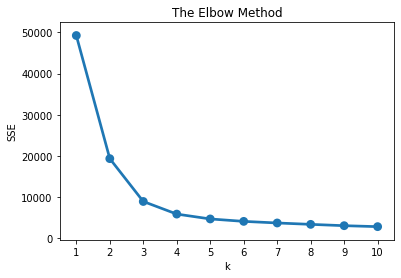

In [9]:
# Add the plot title "The Elbow Method"
plt.title('The Elbow Method')

# Add X-axis label "k"
plt.xlabel('k')

# Add Y-axis label "SSE"
plt.ylabel('SSE')

# Plot SSE values for each key in the dictionary
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [10]:
#get the silhouette score,the closer to 1, the better
for n_clusters in range(2,11):
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(churn_normalized)
    centers = clusterer.cluster_centers_

    score = silhouette_score(churn_normalized, preds)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.5408504123361935)
For n_clusters = 3, silhouette score is 0.5183005213143701)
For n_clusters = 4, silhouette score is 0.4729347644875178)
For n_clusters = 5, silhouette score is 0.42974243885777913)
For n_clusters = 6, silhouette score is 0.393325566500459)
For n_clusters = 7, silhouette score is 0.3505916534753306)
For n_clusters = 8, silhouette score is 0.3249505320281278)
For n_clusters = 9, silhouette score is 0.32997315561720525)
For n_clusters = 10, silhouette score is 0.3313020530937498)


### We choose 4 cluster for the customer segmentation

In [11]:
# choose cluster=4 for KMeans
kmeans = KMeans(n_clusters=4, random_state=1) 

# Fit k-means clustering on the normalized data set
kmeans.fit(churn_normalized)

# Extract cluster labels
cluster_labels = kmeans.labels_

churn_fmt_k4 = churn_fmt.assign(Cluster=cluster_labels)

# Group the data by cluster
group_k4 = churn_fmt_k4.groupby(['Cluster']).agg({
    'Duration': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
  }).round(1)

# Calculate average RFM values and segment sizes per cluster value
group_k4.sort_values(('Monetary','mean'),ascending=False)

Duration Frequency  Monetary      
            mean      mean      mean count
Cluster                                   
3         1751.1      84.8  112031.3  3513
0         1385.8      19.5   10008.3  5634
2          613.0       4.5    1798.0  4362
1            1.8       1.1     618.2  2901

In [12]:
#assign the cluster number back to churn df
churn_cluster=churn_fmt_k4[['Cluster']].reset_index().merge(churn,on='CUSTOMER_SITE_ID')

In [13]:
#name the cluster
rank= {3:'Tier 1',0:"Tier 2",2:"Tier 3",1:"Tier 4"}

churn_cluster['Tier']=churn_cluster['Cluster'].map(rank)
churn_cluster=churn_cluster.drop('Cluster',axis=1)

In [14]:
#get the number of active customer, total number of customer, churn rate per tier
cluster_stat=churn_cluster.groupby('Tier').agg({'Active':['sum','count']}).reset_index()
cluster_stat.columns=['Tier','Active_Customer','Total_Count']
cluster_stat['Churn_Rate']= round(1-(cluster_stat['Active_Customer']/cluster_stat['Total_Count']),4)*100
cluster_stat

,Tier,Active_Customer,Total_Count,Churn_Rate
0,Tier 1,3235,3513,7.91
1,Tier 2,4377,5634,22.31
2,Tier 3,2058,4362,52.82
3,Tier 4,626,2901,78.42


In [15]:
churn_cluster.head()

,CUSTOMER_SITE_ID,TRX_DATE_min,TRX_DATE_max,Monetary,Frequency,Unique_Item_Purchased,Status,Active,Duration,Tier
0,20,2015-01-29,2020-04-07,25135.270000,24,4,Active,1,1896,Tier 2
1,24,2020-03-20,2020-05-11,12408.420000,4,2,Active,1,53,Tier 3
2,36,2015-01-15,2020-04-07,166501.599864,264,20,Active,1,1910,Tier 1
3,86,2015-06-04,2020-05-22,16124.320000,16,4,Active,1,1815,Tier 2
4,90,2015-04-14,2020-04-15,22922.040000,79,5,Active,1,1829,Tier 1


## Assign "Tier" and "Active" back to trx dataframe

In [16]:
status_id=churn_cluster[['CUSTOMER_SITE_ID','Active']].set_index('CUSTOMER_SITE_ID').T.to_dict('records')[0]
tier_id=churn_cluster[['CUSTOMER_SITE_ID','Tier']].set_index('CUSTOMER_SITE_ID').T.to_dict('records')[0]

In [17]:
trx['Tier']=trx['CUSTOMER_SITE_ID'].map(tier_id)
trx['Active']=trx['CUSTOMER_SITE_ID'].map(status_id)

In [18]:
trx.shape

(614866, 51)

## Merge with "price_index" 

In [19]:
#align the shipnumber since I assume "12345" and "00012345" should mean the same customer ship number
def ShipNumber(x):
    if re.search(r'[a-zA-Z]',x):
        return x
    else:
        x = x.zfill(8)
        return x

In [20]:
#create field for data merge key
trx['TRX_YEAR']=trx['TRX_DATE'].dt.year
price_index['TRX_YEAR']=price_index[['yYEAR']]+2000

In [21]:
#align the ship number
trx['SHIP_TO_SITE_NUMBER']=trx['SHIP_TO_SITE_NUMBER'].astype('str')
price_index['Site_ID']=price_index['Site_ID'].astype('str')
trx['ship_number']=trx['SHIP_TO_SITE_NUMBER'].apply(ShipNumber)
price_index['ship_number']=price_index['Site_ID'].apply(ShipNumber)

In [23]:
#keep the record that really have price index information
price_index2=price_index[(price_index['Site_Level_Price_Index']>0)]

In [24]:
#check how many customer site id are still available when we merge the dataframe and create price index related feature
trx[trx['ship_number'].isin(price_index2[price_index2['Site_Level_Price_Index']>0]['ship_number'].values)]\
['CUSTOMER_SITE_ID'].nunique()


16054

In [25]:
#merge based on ship number, item, and transaction year
trxp=trx.merge(price_index2,on=['ship_number','ITEM_ID','TRX_YEAR'])

In [31]:
trx.shape

(614866, 53)

In [26]:
trxp.shape

(602386, 60)

In [ ]:
#trxp.to_csv('customer_revenue_tier_price.csv')
# this data frame is used for building the churn model for each tier of customer next